In [403]:
import pandas as pd
import json

# Decision Tree
Ho visto che il decision tree è il modello che mi offre migliori performance

In [404]:
dataset = pd.read_csv('description_predictions.csv', index_col=0)

dataset_withoutNAN = dataset[dataset.prediction != 'NAN']
dataset_withoutNAN.reset_index(drop=True, inplace=True)

## Feature normalization
È necessaria la normalizzazione delle feature, dato che nel testo abbiamo i nomi delle squadre ed i soprannomi, vado a sostituire tutte le parole relative alla squadra di casa con home team e stessa cosa per la away team.

In [405]:
with open("sinonimi.json") as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

for i, row in dataset_withoutNAN.iterrows():
    h_team, a_team, description, prediction = row.h_team, row.a_team, row.description, row.prediction

    syn = {}
    #cerco nel dizionario di sinonimi, tutti i sinonimi delle squadre del match
    for key in jsonObject.keys():
        if (h_team in key) or (key in h_team):
            syn['home team'] = jsonObject[key] 
            
        if (a_team in key) or (key in a_team):
            syn['away team'] = jsonObject[key] 

    #successivamente prendo il testo e sostituisco i sinonimi con home o away team
    description = description.lower()
    for key in syn.keys():
        for val in syn[key]:
            description = description.replace(val.lower(), key)

    dataset_withoutNAN.at[i, 'description'] = description

In [ ]:

dataset_withoutNAN = dataset_withoutNAN[['description', 'prediction']]
prediction_labels = {
    'N': 0,
    'V': 1,
    'P': 2
}

dataset_withoutNAN['prediction'] = dataset_withoutNAN['prediction'].map(prediction_labels)

## Prediction

In [407]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (2,2), tokenizer = token.tokenize)
text_counts= cv.fit_transform(dataset_withoutNAN.description)

In [408]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, dataset_withoutNAN.prediction, test_size=0.2, random_state=1)

In [409]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as mtr


model = DecisionTreeClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

E = []

report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)
E = {
        'Accuracy': report['accuracy'],
        'Avg Precision (macro)': report['macro avg']['precision'],
        'Avg Recall (macro)': report['macro avg']['recall'],
        'Avg F1-score (macro)': report['macro avg']['f1-score'],
        'Avg Precision (weighted)': report['weighted avg']['precision'],
        'Avg Recall (weighted)': report['weighted avg']['recall'],
        'Avg F1-score (weighted)': report['weighted avg']['f1-score']
}

pd.DataFrame.from_dict(E, orient='index').T

,Accuracy,Avg Precision (macro),Avg Recall (macro),Avg F1-score (macro),Avg Precision (weighted),Avg Recall (weighted),Avg F1-score (weighted)
0,0.802632,0.788434,0.780006,0.783299,0.799278,0.802632,0.800125


In [410]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

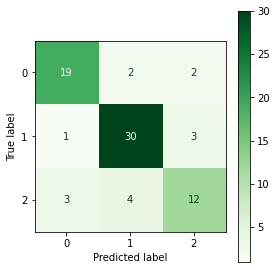

In [414]:
cm = mtr.confusion_matrix(y_test, y_pred)
d = mtr.ConfusionMatrixDisplay(cm, [prediction_labels[label] for label in prediction_labels.keys()])
fig, ax = plt.subplots(figsize=(4,4))
d.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

### Save model

In [412]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))


### Load model

In [413]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8026315789473685
